Descriptive exploration of the data.

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from scipy import stats
import statsmodels.api as sm

def analyze_image_quality_dataset(csv_file):
    """
    Perform comprehensive descriptive analysis on an image quality dataset.
    
    Args:
        csv_file (str): Path to the CSV file containing the dataset
        
    Returns:
        tuple: (data, stats_dict, summary_table) containing the raw panda dataset, the descriptive statistics and a dictionary containing the summary statistics for the table creation 
    """
    # Load the dataset
    data = pd.read_csv(csv_file)
    
    # 1. Basic statistics for numerical scores
    quality_stats = data['Quality'].describe()
    authenticity_stats = data['Authenticity'].describe()
    
    # 2. Calculate additional statistics
    quality_skewness = data['Quality'].skew()
    quality_kurtosis = data['Quality'].kurtosis()
    authenticity_skewness = data['Authenticity'].skew()
    authenticity_kurtosis = data['Authenticity'].kurtosis()
    
    # 3. Correlation between quality and authenticity
    correlation = data['Quality'].corr(data['Authenticity'])
    spearman_corr = data['Quality'].corr(data['Authenticity'], method='spearman')
    
    # 4. Outlier detection using Z-score
    quality_z_scores = np.abs((data['Quality'] - data['Quality'].mean()) / data['Quality'].std())
    authenticity_z_scores = np.abs((data['Authenticity'] - data['Authenticity'].mean()) / data['Authenticity'].std())
    quality_outliers = data[quality_z_scores > 3]
    authenticity_outliers = data[authenticity_z_scores > 3]
    
    # 5. Image metadata statistics (assuming image_path column exists)
    image_sizes = []
    aspect_ratios = []
    file_sizes = []
    
    for img_path in data['image_path']:
        try:
            full_path = os.path.join(os.getcwd(), img_path)
            with Image.open(full_path) as img:
                width, height = img.size
                image_sizes.append((width, height))
                aspect_ratios.append(width / height)
                file_sizes.append(os.path.getsize(full_path) / 1024)  # KB
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
    
    # Create dataframe with image metadata
    image_metadata = pd.DataFrame({
        'width': [size[0] for size in image_sizes],
        'height': [size[1] for size in image_sizes],
        'aspect_ratio': aspect_ratios,
        'file_size_kb': file_sizes
    })
    
    # Compile results dictionary
    results = {
        'quality_stats': quality_stats,
        'authenticity_stats': authenticity_stats,
        'quality_skewness': quality_skewness,
        'quality_kurtosis': quality_kurtosis,
        'authenticity_skewness': authenticity_skewness,
        'authenticity_kurtosis': authenticity_kurtosis,
        'correlation': correlation,
        'spearman_correlation': spearman_corr,
        'quality_outliers_count': len(quality_outliers),
        'authenticity_outliers_count': len(authenticity_outliers),
    }
    
    # Create summary statistics table
    summary_table = pd.DataFrame({
        'Metric': [
            'Sample Size', 
            'Quality Score (Mean)', 
            'Quality Score (Median)', 
            'Quality Score (Std Dev)',
            'Quality Score (Min)',
            'Quality Score (Max)',
            'Quality Score (Skewness)',
            'Quality Score (Kurtosis)',
            'Authenticity Score (Mean)',
            'Authenticity Score (Median)',
            'Authenticity Score (Std Dev)',
            'Authenticity Score (Min)',
            'Authenticity Score (Max)',
            'Authenticity Score (Skewness)',
            'Authenticity Score (Kurtosis)',
            'Correlation (Pearson)',
            'Correlation (Spearman)',
            'Quality Outliers Count',
            'Authenticity Outliers Count',
            
        ],
        'Value': [
            len(data),
            round(quality_stats['mean'], 2),
            round(quality_stats['50%'], 2),
            round(quality_stats['std'], 2),
            round(quality_stats['min'], 2),
            round(quality_stats['max'], 2),
            round(quality_skewness, 2),
            round(quality_kurtosis, 2),
            round(authenticity_stats['mean'], 2),
            round(authenticity_stats['50%'], 2),
            round(authenticity_stats['std'], 2),
            round(authenticity_stats['min'], 2),
            round(authenticity_stats['max'], 2),
            round(authenticity_skewness, 2),
            round(authenticity_kurtosis, 2),
            round(correlation, 2),
            round(spearman_corr, 2),
            len(quality_outliers),
            len(authenticity_outliers),
        ]
    })
    
    # Calculate quartiles for both scores
    quartile_table = pd.DataFrame({
        'Metric': [
            'Quality Score Q1 (25%)',
            'Quality Score Q3 (75%)',
            'Quality Score IQR',
            'Authenticity Score Q1 (25%)',
            'Authenticity Score Q3 (75%)',
            'Authenticity Score IQR'
        ],
        'Value': [
            round(quality_stats['25%'], 2),
            round(quality_stats['75%'], 2),
            round(quality_stats['75%'] - quality_stats['25%'], 2),
            round(authenticity_stats['25%'], 2),
            round(authenticity_stats['75%'], 2),
            round(authenticity_stats['75%'] - authenticity_stats['25%'], 2)
        ]
    })
    
    # Combine the tables
    summary_table = pd.concat([summary_table, quartile_table])
        
    return data, results, summary_table

def visualize_distributions(data):
    """
    Create visualizations for the image quality dataset.
    
    Args:
        data (pd.DataFrame): The dataset to visualize
    """
    # Set up the matplotlib figure
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Histogram with KDE for Quality
    sns.histplot(data['Quality'], kde=True, ax=axes[0, 0], color='skyblue')
    axes[0, 0].set_title('Distribution of Quality Scores')
    axes[0, 0].set_xlabel('Quality Score')
    
    # 2. Histogram with KDE for Authenticity
    sns.histplot(data['Authenticity'], kde=True, ax=axes[0, 1], color='lightgreen')
    axes[0, 1].set_title('Distribution of Authenticity Scores')
    axes[0, 1].set_xlabel('Authenticity Score')
    
    # 3. Box plots
    sns.boxplot(data=[data['Quality'], data['Authenticity']], ax=axes[1, 0])
    axes[1, 0].set_xticklabels(['Quality', 'Authenticity'])
    axes[1, 0].set_title('Box Plots of Scores')
    
    # 4. Scatter plot with regression line
    sns.regplot(x='Quality', y='Authenticity', data=data, ax=axes[1, 1])
    axes[1, 1].set_title('Quality vs. Authenticity')
    
    plt.tight_layout()
    return fig

def check_normality(data, column_names):
    """
    Comprehensive normality assessment for dataset columns.
    
    Args:
        data (pd.DataFrame): The dataset
        column_names (list): List of column names to check for normality
        
    Returns:
        tuple: (normality_results, fig) with test results and visualization
    """
    # Initialize results dictionary
    results = {}
    
    # Create figure for visualizations
    n_columns = len(column_names)
    fig, axes = plt.subplots(n_columns, 3, figsize=(18, 5 * n_columns))
    
    # If only one column, make axes 2D for consistency
    if n_columns == 1:
        axes = np.array([axes])
    
    for i, column in enumerate(column_names):
        values = data[column]
        
        # 1. Shapiro-Wilk test (best for samples < 2000)
        shapiro_test = stats.shapiro(values)
        
        # 2. D'Agostino-Pearson test
        k2, p_k2 = stats.normaltest(values)
        
        # 3. Kolmogorov-Smirnov test
        ks_test = stats.kstest(values, 'norm', args=(values.mean(), values.std()))
        
        # 4. Anderson-Darling test
        ad_test = stats.anderson(values, dist='norm')
        
        # Store test results
        results[column] = {
            'shapiro_test': {
                'statistic': shapiro_test[0],
                'p_value': shapiro_test[1],
                'is_normal': shapiro_test[1] > 0.05
            },
            'dagostino_test': {
                'statistic': k2,
                'p_value': p_k2,
                'is_normal': p_k2 > 0.05
            },
            'ks_test': {
                'statistic': ks_test[0],
                'p_value': ks_test[1],
                'is_normal': ks_test[1] > 0.05
            },
            'anderson_test': {
                'statistic': ad_test[0],
                'critical_values': ad_test[1],
                'significance_levels': ad_test[2],
                'is_normal': ad_test[0] < ad_test[1][2]  # Check against 5% significance level
            },
            'skewness': stats.skew(values),
            'kurtosis': stats.kurtosis(values)
        }
        
        # Visual assessments
        # 1. Histogram with KDE and normal curve
        sns.histplot(values, kde=True, ax=axes[i, 0])
        x = np.linspace(values.min(), values.max(), 100)
        y = stats.norm.pdf(x, values.mean(), values.std())
        axes[i, 0].plot(x, y * len(values) * (values.max() - values.min()) / 10, 'r-', label='Normal Distribution')
        axes[i, 0].set_title(f'Histogram of {column} with Normal Curve')
        axes[i, 0].legend()
        
        # 2. Q-Q Plot
        sm.qqplot(values, line='45', ax=axes[i, 1])
        axes[i, 1].set_title(f'Q-Q Plot for {column}')
        
        # 3. Box plot
        sns.boxplot(x=values, ax=axes[i, 2])
        axes[i, 2].set_title(f'Box Plot for {column}')
    
    plt.tight_layout()
    
    # Create a summary table of test results
    test_names = ['Shapiro-Wilk Test', "D'Agostino-Pearson Test", 'Kolmogorov-Smirnov Test', 'Anderson-Darling Test']
    summary_data = []
    
    for column in column_names:
        row = [column]
        # Add p-values and normality conclusions
        row.append(f"{results[column]['shapiro_test']['p_value']:.4f} ({'Normal' if results[column]['shapiro_test']['is_normal'] else 'Not Normal'})")
        row.append(f"{results[column]['dagostino_test']['p_value']:.4f} ({'Normal' if results[column]['dagostino_test']['is_normal'] else 'Not Normal'})")
        row.append(f"{results[column]['ks_test']['p_value']:.4f} ({'Normal' if results[column]['ks_test']['is_normal'] else 'Not Normal'})")
        row.append(f"{'Normal' if results[column]['anderson_test']['is_normal'] else 'Not Normal'} at 5% level")
        
        # Add shape metrics
        row.append(f"{results[column]['skewness']:.4f}")
        row.append(f"{results[column]['kurtosis']:.4f}")
        
        summary_data.append(row)
    
    # Create DataFrame for summary
    summary_df = pd.DataFrame(
        summary_data, 
        columns=['Column'] + test_names + ['Skewness', 'Kurtosis']
    )
    
    return results, summary_df, fig

def interpret_normality_results(summary_df):
    """
    Provides a clear interpretation of normality test results.
    
    Args:
        summary_df (pd.DataFrame): Summary of normality tests
        
    Returns:
        dict: Interpretations for each column
    """
    interpretations = {}
    
    for _, row in summary_df.iterrows():
        column = row['Column']
        
        # Count how many tests suggest normality
        normal_count = sum(1 for test in ['Shapiro-Wilk Test', "D'Agostino-Pearson Test", 
                                        'Kolmogorov-Smirnov Test', 'Anderson-Darling Test'] 
                          if 'Normal' in row[test] and 'Not Normal' not in row[test])
        
        # Get skewness and kurtosis values
        skewness = float(row['Skewness'])
        kurtosis = float(row['Kurtosis'])
        
        # Determine distribution shape based on skewness
        shape = "normally distributed"
        if abs(skewness) > 0.5:
            shape = "positively skewed" if skewness > 0 else "negatively skewed"
            
        # Determine peakedness based on kurtosis
        peakedness = ""
        if abs(kurtosis) > 0.5:
            peakedness = "leptokurtic (heavy-tailed)" if kurtosis > 0 else "platykurtic (light-tailed)"
        
        # Make overall judgment
        if normal_count >= 3:
            conclusion = "The data appears to be approximately normally distributed."
        elif normal_count == 2:
            conclusion = "The data shows some deviation from normality but may be acceptable for some parametric tests."
        else:
            conclusion = "The data significantly deviates from a normal distribution. Consider non-parametric methods or data transformation."
            
        # Generate transformation recommendation if needed
        transformation = ""
        if normal_count < 3:
            if skewness > 0.5:  # Positive skew
                transformation = "Consider log, square root, or reciprocal transformation."
            elif skewness < -0.5:  # Negative skew
                transformation = "Consider square or cube transformation."
        
        interpretations[column] = {
            'distribution_shape': shape,
            'peakedness': peakedness,
            'conclusion': conclusion,
            'transformation': transformation,
            'normal_test_count': normal_count,
            'total_tests': 4
        }
    
    return interpretations


# Facade function to run the analysis
def run_analysis(csv_file):
    data, results, summary_table = analyze_image_quality_dataset(csv_file)
    distributions = visualize_distributions(data)
    normality_results, normality_summary, normality_fig = check_normality(data, ['Quality', 'Authenticity'])
    normality_interpretations = interpret_normality_results(normality_summary)
    # save the figures
    distributions.savefig('Descriptive/AIGCIQA2023/distributions.png')
    
    return data, results, normality_results, normality_interpretations, normality_summary, normality_fig


RUN THE ANALYSIS

/tmp/ipykernel_1161873/193296121.py:175: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 0].set_xticklabels(['Quality', 'Authenticity'])


{'quality_stats': count    2400.000000
mean       49.922704
std         9.316361
min        26.627285
25%        41.627909
50%        50.753468
75%        57.530844
max        72.110398
Name: Quality, dtype: float64, 'authenticity_stats': count    2400.000000
mean       49.766913
std         8.058066
min        28.417939
25%        43.413960
50%        49.924035
75%        55.573257
max        73.719142
Name: Authenticity, dtype: float64, 'quality_skewness': np.float64(-0.010931418907067628), 'quality_kurtosis': np.float64(-1.0576008426532728), 'authenticity_skewness': np.float64(0.06652414138150618), 'authenticity_kurtosis': np.float64(-0.6328227023054134), 'correlation': np.float64(0.8613855798977418), 'spearman_correlation': np.float64(0.8623424578719545), 'quality_outliers_count': 0, 'authenticity_outliers_count': 0}
{'Quality': {'shapiro_test': {'statistic': np.float64(0.9703815873123834), 'p_value': np.float64(7.348652657797054e-22), 'is_normal': np.False_}, 'dagostino_test': {'s

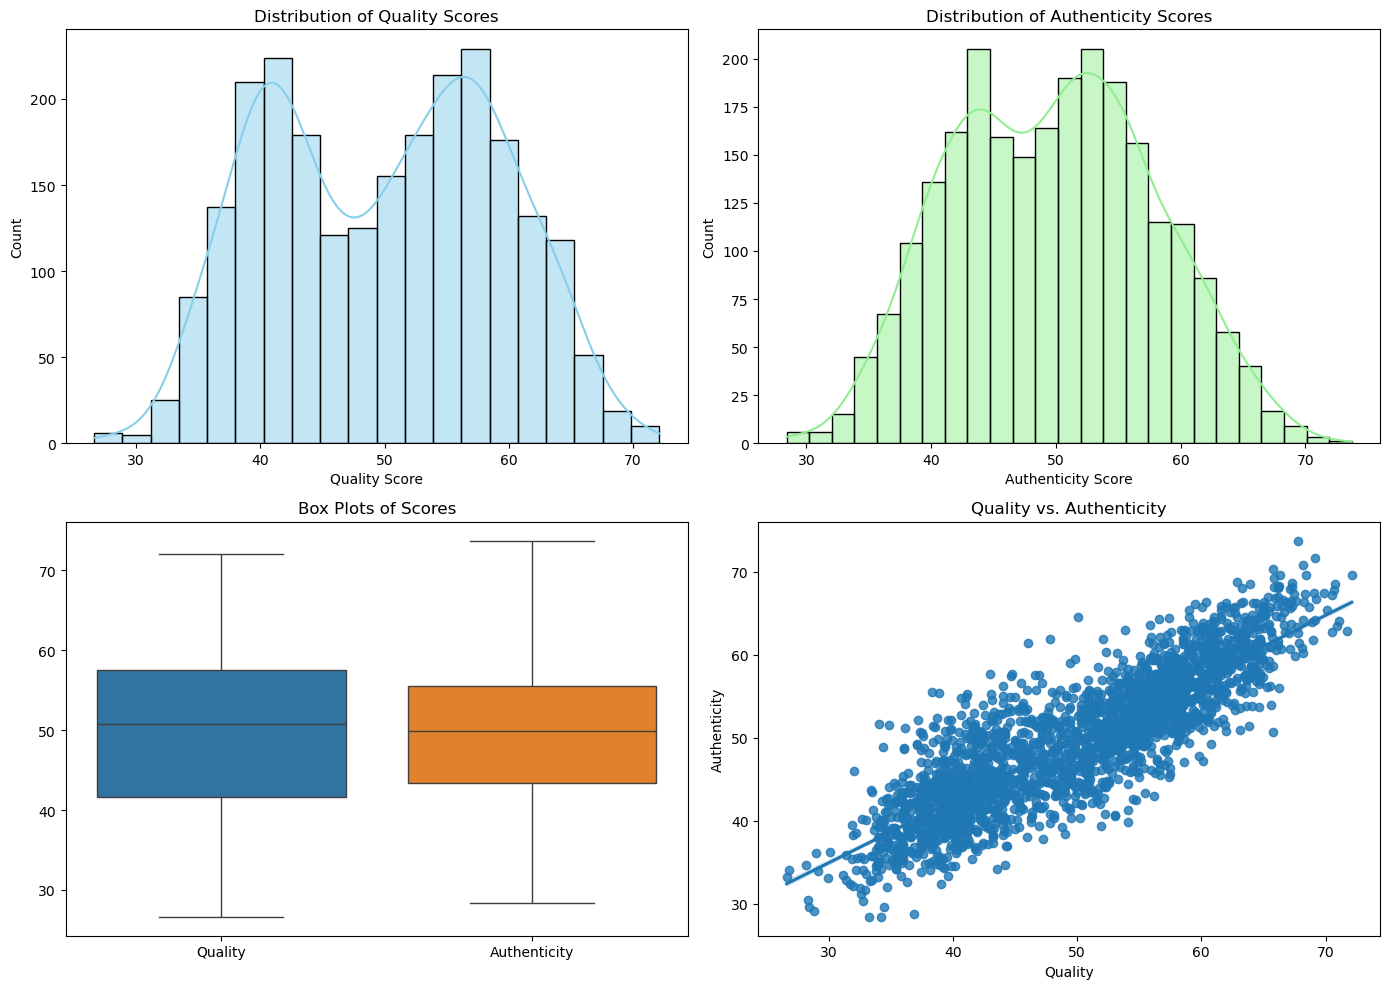

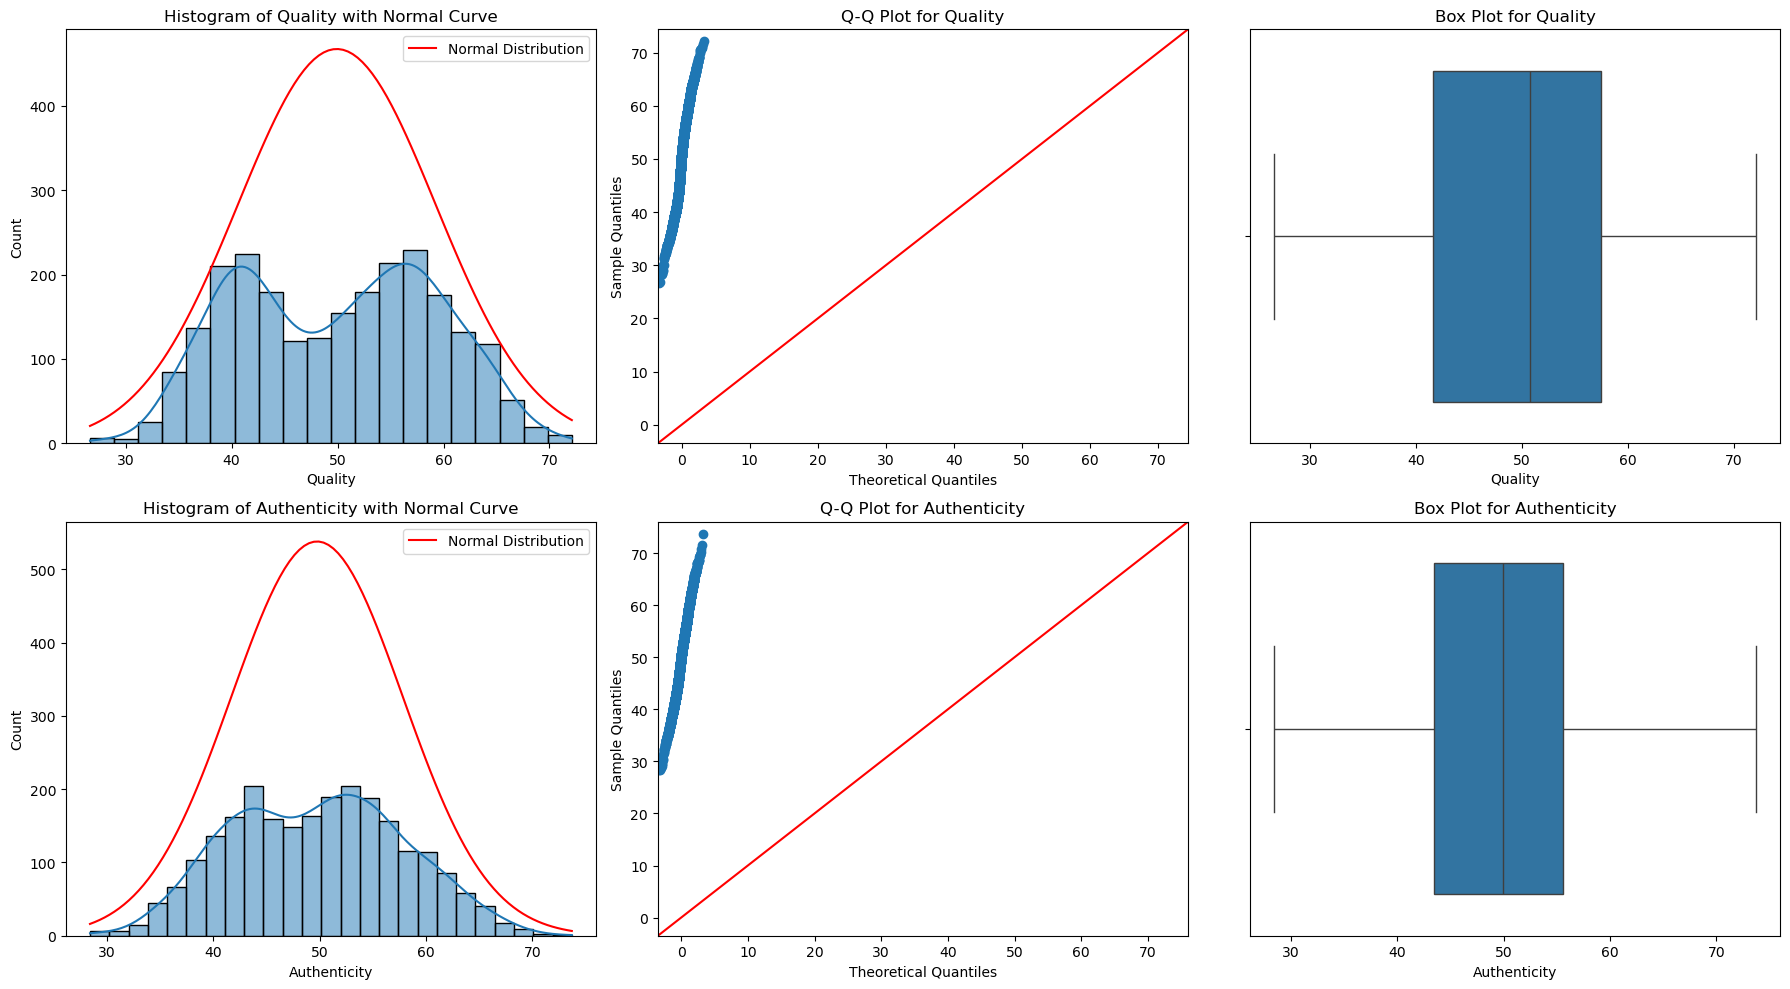

In [ ]:

data, results, normality_results, normality_interpretations, normality_summary, normality_fig = run_analysis('Dataset/AIGCIQA2023/mos_data.csv')
print(results)
print(normality_results)
print(normality_interpretations)
print(normality_summary)

plt.show()

Bimodality-check

In [37]:
from sklearn.mixture import GaussianMixture
from diptest import diptest

def visualize_distribution(data, column='Quality'):
    """Visualize distribution to check for bimodality"""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Histogram with different bin sizes
    sns.histplot(data[column], bins=20, kde=False, ax=axes[0, 0])
    axes[0, 0].set_title(f'{column} Distribution (20 bins)')
    
    sns.histplot(data[column], bins=40, kde=False, ax=axes[0, 1])
    axes[0, 1].set_title(f'{column} Distribution (40 bins)')
    
    # Kernel Density Estimation (KDE) plot
    sns.kdeplot(data[column], ax=axes[1, 0], fill=True)
    axes[1, 0].set_title(f'{column} Density Estimation')
    
    # Histogram with KDE overlay and rug plot
    sns.histplot(data[column], kde=True, ax=axes[1, 1])
    sns.rugplot(data[column], ax=axes[1, 1], color='red')
    axes[1, 1].set_title(f'{column} Distribution with KDE')
    
    plt.tight_layout()
    return fig

def test_bimodality(data, column='Quality'):
    """Calculate statistical metrics to test for bimodality"""
    values = data[column].values
    
    # 1. Bimodality Coefficient (BC)
    skewness = stats.skew(values)
    kurtosis = stats.kurtosis(values)
    n = len(values)
    bimodality_coef = (skewness**2 + 1) / (kurtosis + 3*((n-1)**2)/((n-2)*(n-3)))
    
    # BC > 0.555 suggests bimodality (0.555 is BC for uniform distribution)
    
    # 2. Hartigan's Dip Test (if available)
    try:
        dip, p_value = diptest(values)
        hartigan_result = {"dip_statistic": dip, "p_value": p_value}
        # p < 0.05 suggests non-unimodality
    except ImportError:
        hartigan_result = "diptest package not available"
    
    # 3. Check if kurtosis is negative (platykurtic)
    # Bimodal distributions typically have negative kurtosis
    
    return {
        "bimodality_coefficient": bimodality_coef,
        "suggests_bimodal": bimodality_coef > 0.555,
        "skewness": skewness,
        "kurtosis": kurtosis,
        "kurtosis_suggests_bimodal": kurtosis < 0,
        "hartigans_test": hartigan_result
    }

def gmm_analysis(data, column='Quality', max_components=5):
    """Use Gaussian Mixture Models to identify number of components"""
    X = data[column].values.reshape(-1, 1)
    
    # Track BIC and AIC for different component counts
    bic_scores = []
    aic_scores = []
    
    for n_components in range(1, max_components+1):
        gmm = GaussianMixture(n_components=n_components, random_state=42)
        gmm.fit(X)
        bic_scores.append(gmm.bic(X))
        aic_scores.append(gmm.aic(X))
    
    # Plot information criteria
    fig, ax = plt.subplots(figsize=(10, 6))
    components = range(1, max_components+1)
    ax.plot(components, bic_scores, 'o-', label='BIC')
    ax.plot(components, aic_scores, 's-', label='AIC')
    ax.set_xlabel('Number of Components')
    ax.set_ylabel('Information Criterion')
    ax.set_title('Model Selection for Number of Components')
    ax.legend()
    
    # Fit optimal model (according to BIC)
    optimal_components = np.argmin(bic_scores) + 1
    optimal_gmm = GaussianMixture(n_components=optimal_components, random_state=42)
    optimal_gmm.fit(X)
    
    # Visualize the mixture
    x = np.linspace(data[column].min(), data[column].max(), 1000).reshape(-1, 1)
    logprob = np.zeros(len(x))
    
    fig2, ax2 = plt.subplots(figsize=(10, 6))
    sns.histplot(data[column], bins=30, kde=False, stat='density', alpha=0.5, ax=ax2)
    
    for i in range(optimal_components):
        pdf = stats.norm.pdf(x.ravel(), 
                            optimal_gmm.means_[i][0], 
                            np.sqrt(optimal_gmm.covariances_[i][0][0]))
        
        ax2.plot(x, pdf * optimal_gmm.weights_[i], 
                label=f'Component {i+1}: μ={optimal_gmm.means_[i][0]:.2f}, σ={np.sqrt(optimal_gmm.covariances_[i][0][0]):.2f}')
        logprob += pdf.ravel() * optimal_gmm.weights_[i]
    
    ax2.plot(x, logprob, 'k-', label='Mixture Model', linewidth=2)
    ax2.set_title(f'Gaussian Mixture Model with {optimal_components} Components')
    ax2.legend()
    
    return {
        "optimal_components": optimal_components,
        "suggests_bimodal": optimal_components == 2,
        "bic_scores": bic_scores,
        "aic_scores": aic_scores,
        "gmm_model": optimal_gmm,
        "figures": [fig, fig2]
    }

def peak_analysis(data, column='Quality'):
    """Detect peaks and valleys in the distribution"""
    # Calculate KDE
    kde = stats.gaussian_kde(data[column])
    x = np.linspace(data[column].min(), data[column].max(), 1000)
    y = kde(x)
    
    # Find peaks (local maxima)
    peaks = []
    for i in range(1, len(y)-1):
        if y[i-1] < y[i] > y[i+1]:
            peaks.append((x[i], y[i]))
    
    # Find valleys (local minima)
    valleys = []
    for i in range(1, len(y)-1):
        if y[i-1] > y[i] < y[i+1]:
            valleys.append((x[i], y[i]))
    
    # Visualize
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(x, y, 'k-', linewidth=2)
    
    # Mark peaks
    for px, py in peaks:
        ax.plot(px, py, 'ro', markersize=8)
        ax.text(px, py*1.05, f'Peak: {px:.2f}', ha='center')
    
    # Mark valleys
    for vx, vy in valleys:
        ax.plot(vx, vy, 'go', markersize=8)
        ax.text(vx, vy*0.95, f'Valley: {vx:.2f}', ha='center')
    
    ax.set_title(f'Peak and Valley Detection for {column}')
    
    # Calculate valley depth ratio if bimodal
    if len(peaks) >= 2 and len(valleys) >= 1:
        # Sort peaks and valleys by x position
        sorted_peaks = sorted(peaks, key=lambda p: p[0])
        sorted_valleys = sorted(valleys, key=lambda v: v[0])
        
        # Find valleys between the first and last peak
        valleys_between = [v for v in sorted_valleys 
                          if sorted_peaks[0][0] < v[0] < sorted_peaks[-1][0]]
        
        if valleys_between:
            # Use the deepest valley
            deepest_valley = min(valleys_between, key=lambda v: v[1])
            valley_x, valley_y = deepest_valley
            
            # Get heights of adjacent peaks
            left_peaks = [p for p in peaks if p[0] < valley_x]
            right_peaks = [p for p in peaks if p[0] > valley_x]
            
            if left_peaks and right_peaks:
                left_peak_y = max(left_peaks, key=lambda p: p[1])[1]
                right_peak_y = max(right_peaks, key=lambda p: p[1])[1]
                
                min_peak_height = min(left_peak_y, right_peak_y)
                valley_depth = min_peak_height - valley_y
                valley_ratio = valley_depth / min_peak_height
                
                # Add visualization of valley depth
                ax.plot([valley_x, valley_x], [valley_y, min_peak_height], 'b--')
                ax.text(valley_x*1.05, (valley_y + min_peak_height)/2, 
                       f'Depth Ratio: {valley_ratio:.2f}', va='center')
                
                # Valley ratio > 0.1 typically indicates meaningful separation
                return {
                    "num_peaks": len(peaks),
                    "num_valleys": len(valleys),
                    "peaks": peaks,
                    "valleys": valleys,
                    "valley_depth_ratio": valley_ratio,
                    "suggests_bimodal": valley_ratio > 0.1 and len(peaks) >= 2,
                    "figure": fig
                }
    
    return {
        "num_peaks": len(peaks),
        "num_valleys": len(valleys),
        "peaks": peaks,
        "valleys": valleys,
        "valley_depth_ratio": None,
        "suggests_bimodal": len(peaks) >= 2,
        "figure": fig
    }

def check_bimodality(data, column='Quality'):
    """Run all bimodality tests and provide a comprehensive assessment"""
    # Run all tests
    visual_fig = visualize_distribution(data, column)
    stat_results = test_bimodality(data, column)
    gmm_results = gmm_analysis(data, column)
    peak_results = peak_analysis(data, column)
    
    # Count evidence for bimodality
    evidence = [
        stat_results["suggests_bimodal"],  # Bimodality coefficient
        stat_results["kurtosis_suggests_bimodal"],  # Negative kurtosis
        gmm_results["suggests_bimodal"],  # GMM optimal components = 2
        peak_results["suggests_bimodal"]  # Multiple peaks with significant valley
    ]
    
    # If Hartigan's test is available, add its result
    if isinstance(stat_results["hartigans_test"], dict):
        hartigan_suggests_bimodal = stat_results["hartigans_test"]["p_value"] < 0.05
        evidence.append(hartigan_suggests_bimodal)
    
    # Calculate confidence score
    confidence = sum(evidence) / len(evidence)
    
    # Make final determination
    if confidence >= 0.6:
        if gmm_results["optimal_components"] > 2:
            conclusion = "Multimodal distribution (more than two modes)"
        else:
            conclusion = "Bimodal distribution"
    else:
        conclusion = "Unimodal distribution"
    
    return {
        "conclusion": conclusion,
        "confidence": confidence,
        "statistical_tests": stat_results,
        "gmm_analysis": gmm_results,
        "peak_analysis": peak_results,
        "figures": [visual_fig] + gmm_results["figures"] + [peak_results["figure"]]
    }


RUN THE BIMODALITY-CHECK

{'conclusion': 'Bimodal distribution', 'confidence': np.float64(0.8), 'statistical_tests': {'bimodality_coefficient': np.float64(0.5139735900717478), 'suggests_bimodal': np.False_, 'skewness': np.float64(-0.010924585583767464), 'kurtosis': np.float64(-1.0578977512280925), 'kurtosis_suggests_bimodal': np.True_, 'hartigans_test': {'dip_statistic': 0.02724904329578307, 'p_value': 0.0}}, 'gmm_analysis': {'optimal_components': np.int64(2), 'suggests_bimodal': np.True_, 'bic_scores': [np.float64(3158.4623987086416), np.float64(2778.378856934659), np.float64(2792.026838891654), np.float64(2823.6220893935288), np.float64(2837.8244347894365)], 'aic_scores': [np.float64(3146.8959506759693), np.float64(2749.4627368529787), np.float64(2745.7610467609657), np.float64(2760.006625213832), np.float64(2756.859298560732)], 'gmm_model': GaussianMixture(n_components=np.int64(2), random_state=42), 'figures': [<Figure size 1000x600 with 1 Axes>, <Figure size 1000x600 with 1 Axes>]}, 'peak_analysis': {'num_p

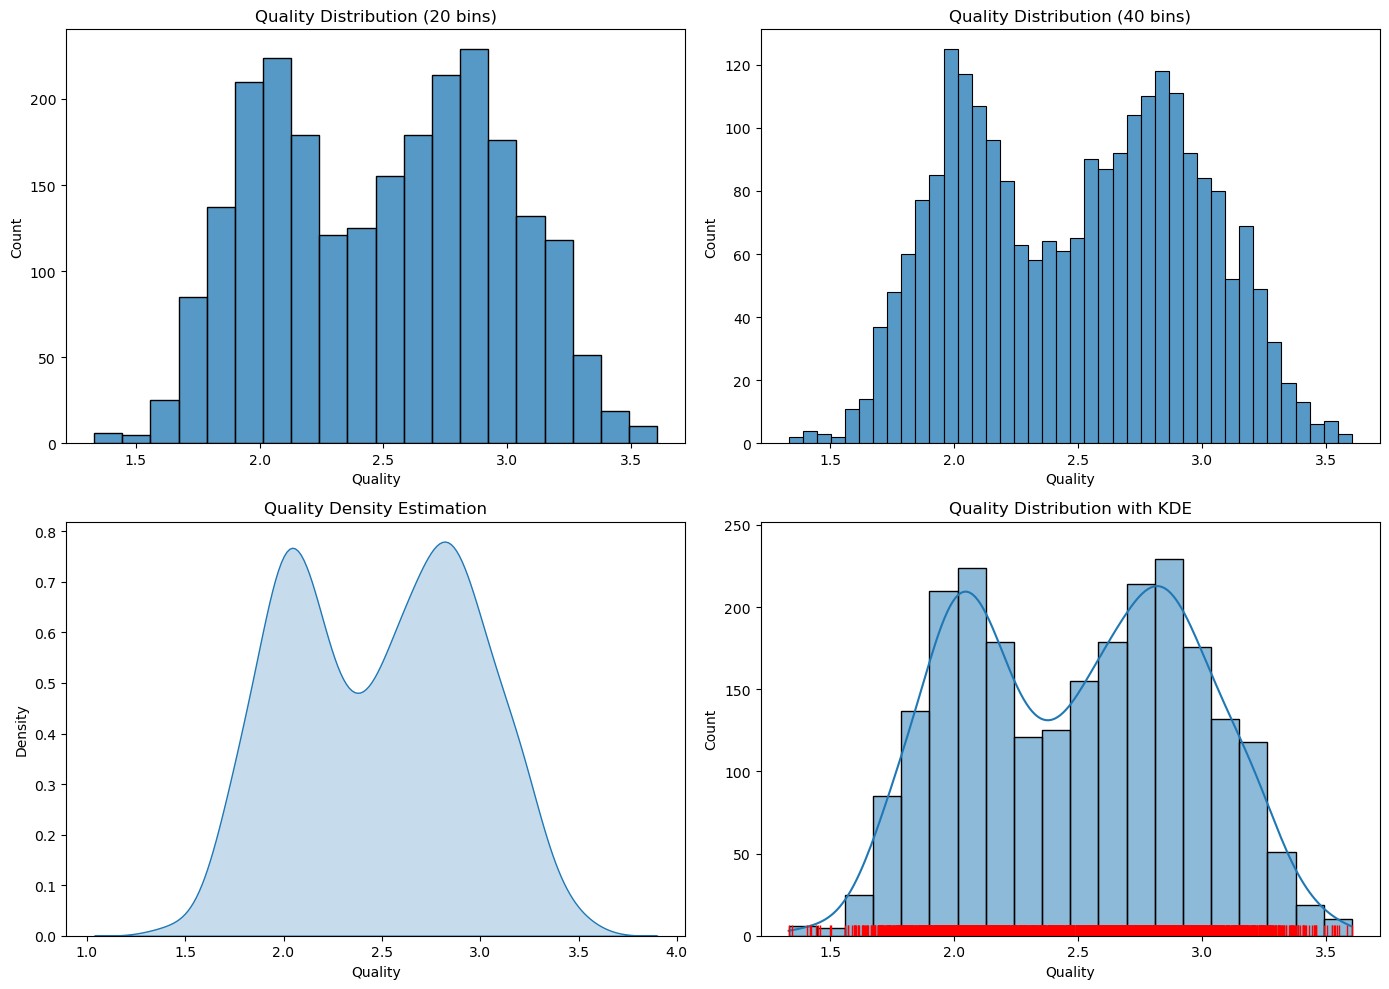

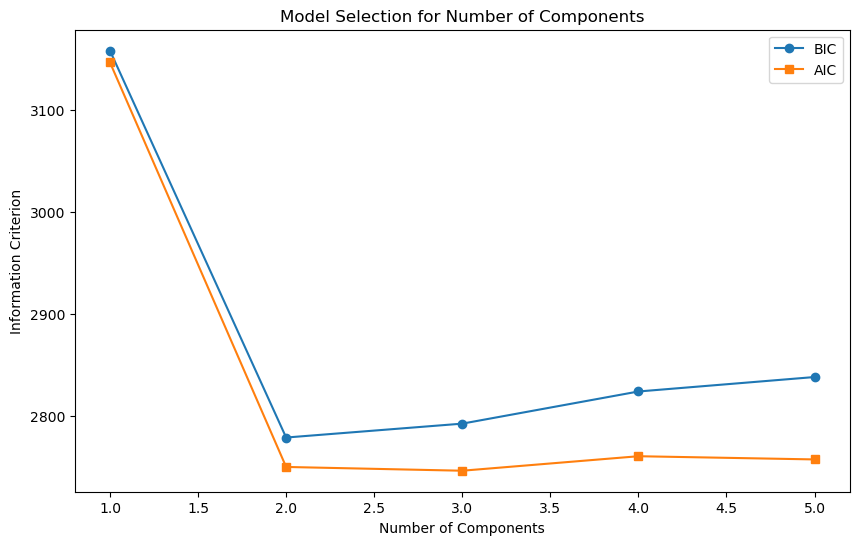

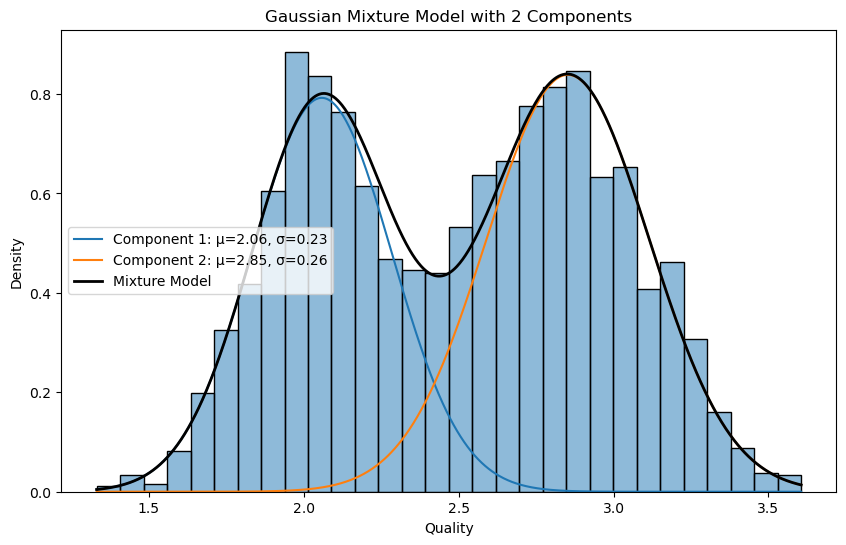

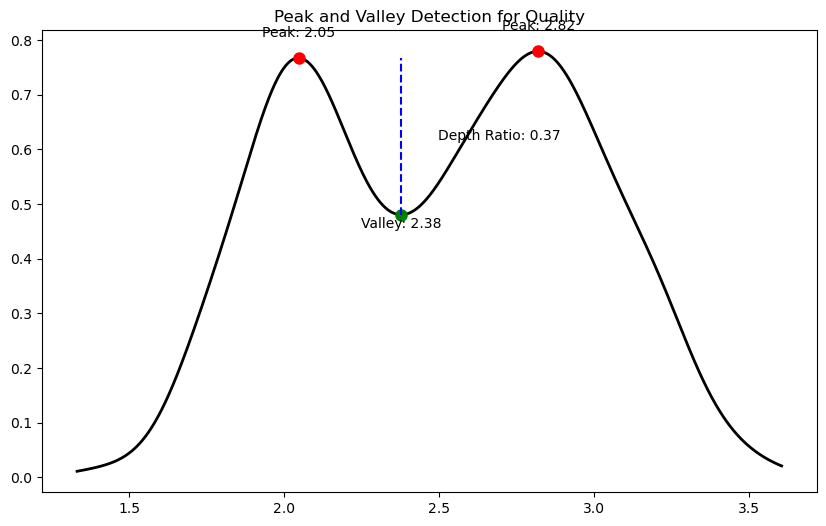

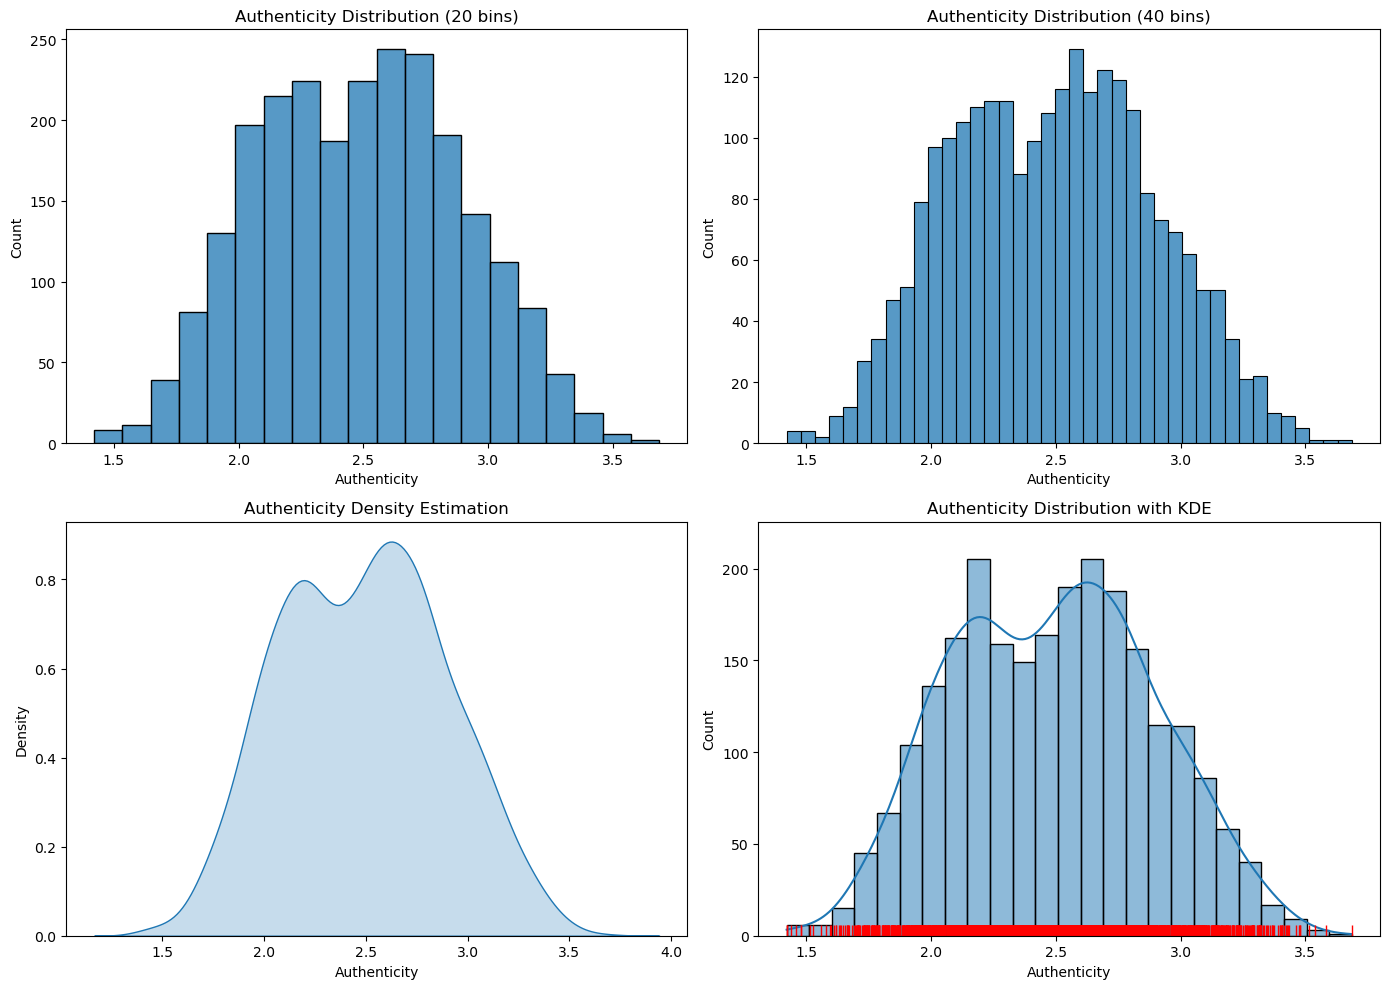

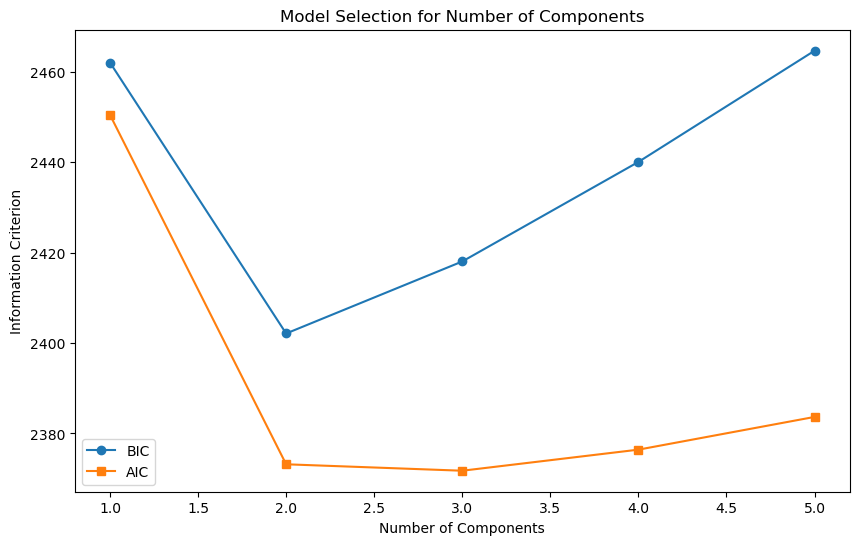

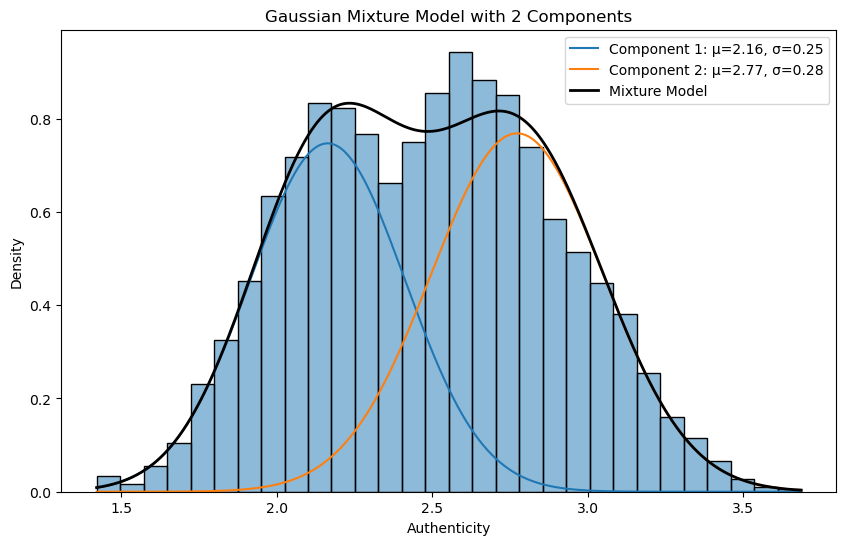

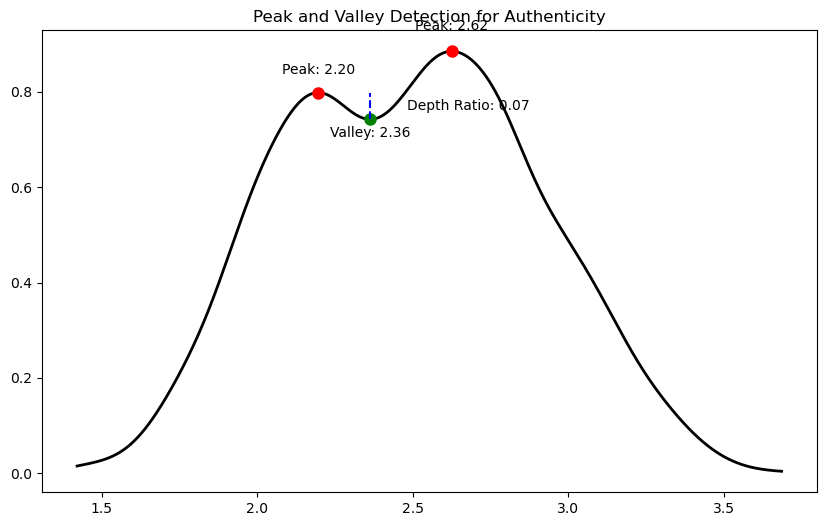

In [41]:

quality_bimodal_results = check_bimodality(data, 'Quality')
print(quality_bimodal_results)

authenticity_bimodal_results = check_bimodality(data, 'Authenticity')
print(authenticity_bimodal_results)



# Image Quality Assessment Dataset: Comprehensive Descriptive Analysis

## 1. Dataset Overview

The analysis examines an image quality assessment dataset containing 2,400 images with two primary metrics:
- **Quality Scores**: Numerical ratings evaluating overall image quality
- **Authenticity Scores**: Numerical ratings assessing image authenticity

Each image is evaluated along these two dimensions, creating a multivariate quality assessment framework.

## 2. Basic Statistical Measures

### 2.1 Quality Scores

| Statistic | Value |
|-----------|-------|
| Count | 2,400 |
| Mean | 49.92 |
| Median | 50.75 |
| Standard Deviation | 9.32 |
| Minimum | 26.63 |
| Maximum | 72.11 |
| 25th Percentile (Q1) | 41.63 |
| 75th Percentile (Q3) | 57.53 |
| Interquartile Range (IQR) | 15.90 |
| Skewness | -0.01 |
| Kurtosis | -1.06 |

### 2.2 Authenticity Scores

| Statistic | Value |
|-----------|-------|
| Count | 2,400 |
| Mean | 49.77 |
| Median | 49.92 |
| Standard Deviation | 8.06 |
| Minimum | 28.42 |
| Maximum | 73.72 |
| 25th Percentile (Q1) | 43.41 |
| 75th Percentile (Q3) | 55.57 |
| Interquartile Range (IQR) | 12.16 |
| Skewness | 0.07 |
| Kurtosis | -0.63 |

### 2.3 Outlier Analysis

No significant outliers were detected in either Quality or Authenticity scores using the z-score method (±3 standard deviations), suggesting a dataset without extreme values.

## 3. Distribution Analysis

### 3.1 Quality Scores Distribution

The Quality scores exhibit a **strong bimodal distribution** with the following characteristics:

- **Distribution Pattern**: Two distinct peaks with a significant valley between them
- **Confidence in Bimodality**: 80%
- **Bimodality Coefficient**: 0.514 (approaching the threshold of 0.555)
- **Kurtosis**: -1.06 (strongly negative, indicating platykurtosis)
- **Hartigan's Dip Test**: p-value of 0.0 (strong evidence against unimodality)
- **Valley Depth Ratio**: 0.374 (substantial separation between modes)
- **Optimal Components**: Gaussian Mixture Model analysis confirms 2 distinct components
- **Mode Locations**: Peaks approximately at 42 and 57

The strongly platykurtic distribution (negative kurtosis) with dual peaks indicates the presence of two distinct subpopulations in the image quality assessment.

### 3.2 Authenticity Scores Distribution

The Authenticity scores show a **primarily unimodal distribution** with slight structural complexity:

- **Distribution Pattern**: Primarily single-peaked with minor secondary structure
- **Confidence in Unimodality**: 60% (40% for bimodality)
- **Bimodality Coefficient**: 0.424 (below the threshold of 0.555)
- **Kurtosis**: -0.63 (moderately negative)
- **Hartigan's Dip Test**: p-value of 0.424 (fails to reject unimodality)
- **Valley Depth Ratio**: 0.070 (minimal separation between potential modes)
- **Optimal Components**: GMM analysis suggests 2 components, but with less distinct separation

The authenticity distribution exhibits a more continuous spread compared to the clearly divided quality scores.

### 3.3 Normality Tests

| Test | Quality Score Result | Authenticity Score Result |
|------|----------------------|---------------------------|
| Shapiro-Wilk | p < 0.0001 (Not Normal) | p < 0.0001 (Not Normal) |
| D'Agostino-Pearson | p < 0.0001 (Not Normal) | p < 0.0001 (Not Normal) |
| Kolmogorov-Smirnov | p < 0.0001 (Not Normal) | p = 0.0001 (Not Normal) |
| Anderson-Darling | Not Normal at 5% level | Not Normal at 5% level |

All normality tests definitively reject the null hypothesis of normality for both measures, confirming non-normal distributions.

## 4. Correlation Analysis

### 4.1 Correlation Metrics

| Correlation Type | Value |
|------------------|-------|
| Pearson Correlation | 0.86 |
| Spearman Rank Correlation | 0.86 |

The strong and nearly identical Pearson and Spearman correlation coefficients (0.86) indicate a **robust, linear relationship** between Quality and Authenticity scores that holds across the entire dataset regardless of parametric assumptions.

# 5. Implications for DNN Training

# Current Approach: Joint MSE Loss

You're currently using MSE loss to predict both quality and authenticity together. While this is a common approach, the bimodal distribution of quality scores introduces significant challenges:

## Problems with MSE for Your Data

### For Quality Scores (Bimodal):

1. **Regression to the Valley**:
   - MSE inherently predicts values near the distribution mean (~50)
   - This falls precisely in the valley between your two modes (~42 and ~57)
   - Result: Your model is likely being trained to predict values that rarely occur in your actual data

2. **Biased Predictions**:
   - Quality predictions will be systematically pulled toward the middle
   - High-quality images (second mode ~57) will be underpredicted
   - Low-quality images (first mode ~42) will be overpredicted

3. **Misleading Evaluation**:
   - A seemingly decent MSE might mask the fact that predictions don't match the actual bimodal distribution
   - Your model may never predict values at the actual peaks where most ground truth values exist

### For Authenticity Scores (Unimodal but Non-Normal):

1. **Better but Still Suboptimal**:
   - Less problematic than for quality scores
   - However, the platykurtic (flat) distribution still violates MSE's normality assumption

